In [ ]:
# Jupyter cell 0: imports & paths
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm



ROOT     = Path.cwd().parent  
SEQ_DIR  = ROOT / "data" / "sequences"
PROC_DIR = ROOT / "data" / "processed"
OUT_DIR  = ROOT / "assets" / "figs"
TAB_DIR  = ROOT / "assets" / "tables"
OUT_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

# Files
STATES_NPY   = SEQ_DIR / "states_10min.npy"
GRID_IDS_CSV = SEQ_DIR / "grid_ids.csv"
CATALOG_JSON = SEQ_DIR / "state_catalog.json"

SUBGROUPS_PARQ = PROC_DIR / "subgroups.parquet"  # respondent meta

# Plot config (journal-friendly)
plt.rcParams.update({
    "figure.figsize": (7, 3.5),   # one-column width
    "figure.dpi": 150,
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "savefig.bbox": "tight"
})


In [ ]:
# Jupyter cell 1: load core datasets
states = np.load(STATES_NPY)   # [N,144] int state ids
ids_df = pd.read_csv(GRID_IDS_CSV, dtype={"TUCASEID": "int64"})
ids = ids_df["TUCASEID"].to_numpy()

with open(CATALOG_JSON, "r") as f:
    catalog = json.load(f)

# id<->label maps (keys in JSON may be str)
id_to_sub = {int(k): v for k, v in catalog["id_to_sub"].items()}
sub_to_id = {k: int(v) for k, v in catalog["sub_to_id"].items()}

K = 1 + max(id_to_sub)  # number of states (assumes consecutive IDs starting at 0)

# Load respondent meta (subgroups)
meta = pd.read_parquet(SUBGROUPS_PARQ, engine="fastparquet")

# Ensure weight column exists and is scaled (ATUS/CPS use 4 implied decimals)
if "weight" not in meta.columns:
    if "TUFNWGTP" in meta.columns:
        w = meta["TUFNWGTP"].astype("float64")
        #meta["weight"] = np.where(w.median() > 1e6, w / 1e4, w)
        meta["weight"] = 1.0
    else:
        meta["weight"] = 1.0

# Align meta to the order of states/ids
meta_aligned = ids_df.merge(meta, on="TUCASEID", how="left")
meta_aligned["weight"] = meta_aligned["weight"].fillna(1.0)

# Convenience arrays
w = meta_aligned["weight"].to_numpy("float64")            # [N]
sex = meta_aligned.get("sex", pd.Series(["Unknown"]*len(meta_aligned))).astype("string")
employment = meta_aligned.get("employment", pd.Series(["Unknown"]*len(meta_aligned))).astype("string")
day_type = meta_aligned.get("day_type", pd.Series(["Unknown"]*len(meta_aligned))).astype("string")
hh_band = meta_aligned.get("hh_size_band", pd.Series(["Unknown"]*len(meta_aligned))).astype("string")
region = meta_aligned.get("region", pd.Series(["Unknown"]*len(meta_aligned))).astype("string")
month = meta_aligned.get("month", pd.Series(["Unknown"]*len(meta_aligned))).astype("string")

print(f"states: {states.shape}, K={K}, N={states.shape[0]}")
print(meta_aligned.head(3))


states: (252808, 144), K=15, N=252808
         TUCASEID     sex hh_size_band month region  employment day_type  \
0  20030100013280    Male            3     1   West  Unemployed  Weekday   
1  20030100013344  Female        4plus     1   West    Employed  Weekend   
2  20030100013352  Female            2     1   West     Unknown  Weekend   

       TUFNWGTP  weight  
0  8.155463e+06     1.0  
1  1.735323e+06     1.0  
2  3.830527e+06     1.0  


In [ ]:
id_to_sub

{1: 'COOKING',
 2: 'DISHWASHING',
 3: 'LAUNDRY_IRON',
 4: 'CLEANING_ELECTRIC',
 5: 'SCREENS_LEISURE',
 6: 'ADMIN_ON_DEVICES',
 7: 'APPLIANCE_HOUSEHOLD_ELEC',
 8: 'SLEEP',
 9: 'EAT_DRINK',
 10: 'PERSONAL_CARE',
 11: 'CARE_AT_HOME',
 12: 'QUIET_SOCIAL',
 13: 'EXERCISE_NO_MACHINE',
 14: 'OUT_OF_HOME'}

In [ ]:
meta

,TUCASEID,sex,hh_size_band,month,region,employment,day_type,TUFNWGTP,weight
0,20030100013280,Male,3,1,West,Unemployed,Weekday,8.155463e+06,1.0
1,20030100013344,Female,4plus,1,West,Employed,Weekend,1.735323e+06,1.0
2,20030100013352,Female,2,1,West,Unknown,Weekend,3.830527e+06,1.0
3,20030100013848,Female,4plus,1,South,Employed,Weekday,6.622023e+06,1.0
4,20030100014165,Male,4plus,1,South,Employed,Weekday,3.068387e+06,1.0
...,...,...,...,...,...,...,...,...,...
252803,20241212242238,Female,2,12,Northeast,Unknown,Weekday,2.293753e+07,1.0
252804,20241212242273,Female,2,12,West,Employed,Weekday,1.027231e+07,1.0
252805,20241212242280,Female,1,12,South,Employed,Weekday,5.305072e+06,1.0
252806,20241212242281,Male,4plus,12,South,Employed,Weekend,8.865700e+06,1.0


In [ ]:
def slot_minutes():
    """Vector of 144 within-day minutes at 10-min resolution."""
    return np.arange(144) * 10

def label_for(state_id: int) -> str:
    return id_to_sub.get(state_id, f"STATE_{state_id}")

def weighted_occupancy(states, weights, K):
    """
    Compute weighted occupancy p_s(t): Kx144
    p_s(t) = sum_n w_n * 1{X_{n,t}=s} / sum_n w_n
    """
    N, T = states.shape
    out = np.zeros((K, T), dtype="float64")
    for t in range(T):
        col = states[:, t]
        # accumulate weights by state
        np.add.at(out[:, t], col, weights)
    denom = weights.sum()
    if denom > 0:
        out /= denom
    return out

def weighted_transition_matrix(states, weights, K):
    """
    Weighted (first-order) transition counts over the full day, then row-normalized.
    Weights apply per person uniformly across their 143 transitions.
    """
    counts = np.zeros((K, K), dtype="float64")
    for n in range(states.shape[0]):
        seq = states[n]
        src = seq[:-1]
        dst = seq[1:]
        # add w[n] to each observed pair
        np.add.at(counts, (src, dst), weights[n])
    # Row-normalize
    row_sums = counts.sum(axis=1, keepdims=True)
    probs = np.divide(counts, row_sums, where=row_sums > 0)
    return counts, probs

def dwell_time_samples(states, target_state):
    """
    Return a list of run lengths (in slots) for target_state across all people.
    Slots are 10 minutes each.
    """
    runs = []
    for row in states:
        x = (row == target_state).astype(int)
        if x.sum() == 0:
            continue
        # run-length encoding
        # positions where state changes (pad ends)
        diff = np.diff(np.concatenate(([0], x, [0])))
        starts = np.where(diff == 1)[0]
        ends   = np.where(diff == -1)[0]
        runs.extend((ends - starts).tolist())
    return runs

def to_table(df, name):
    """Save table as CSV and LaTeX for the paper."""
    csv_path = TAB_DIR / f"{name}.csv"
    tex_path = TAB_DIR / f"{name}.tex"
    df.to_csv(csv_path, index=False)
    try:
        with open(tex_path, "w") as f:
            f.write(df.to_latex(index=False, float_format="%.3f"))
    except Exception:
        pass
    return csv_path, tex_path

def top_time_share(occ, top=10):
    """Return top states by average occupancy (share of day)."""
    share = occ.mean(axis=1)  # K
    df = pd.DataFrame({
        "state_id": np.arange(len(share)),
        "state": [label_for(i) for i in range(len(share))],
        "share": share,
        "minutes_per_day": share * 144 * 10
    }).sort_values("share", ascending=False).head(top)
    return df


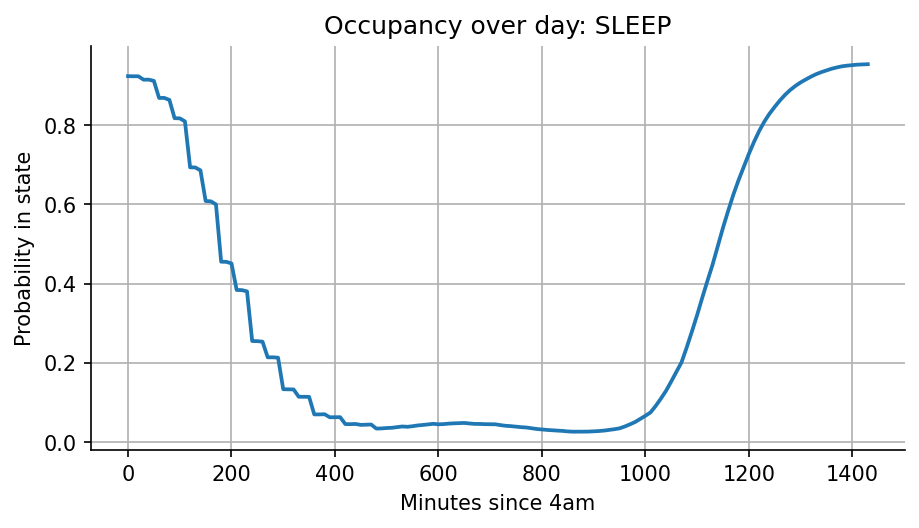

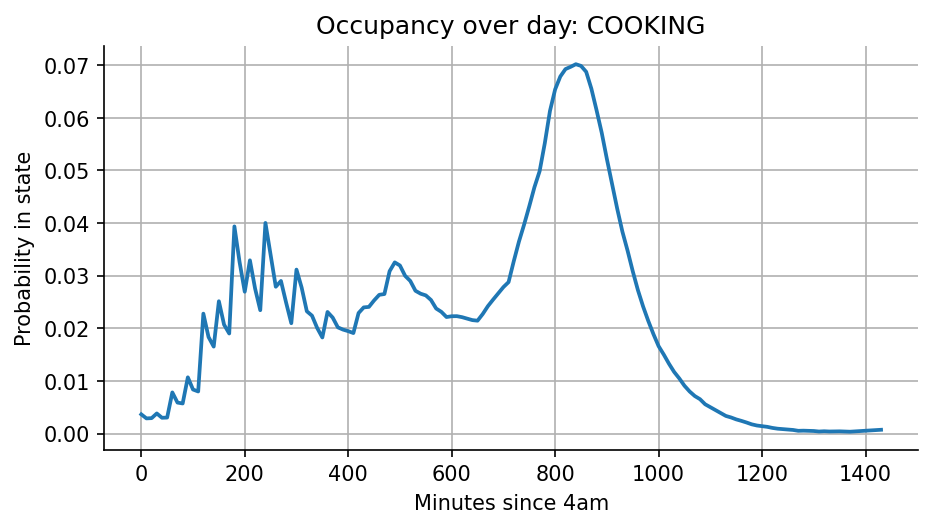

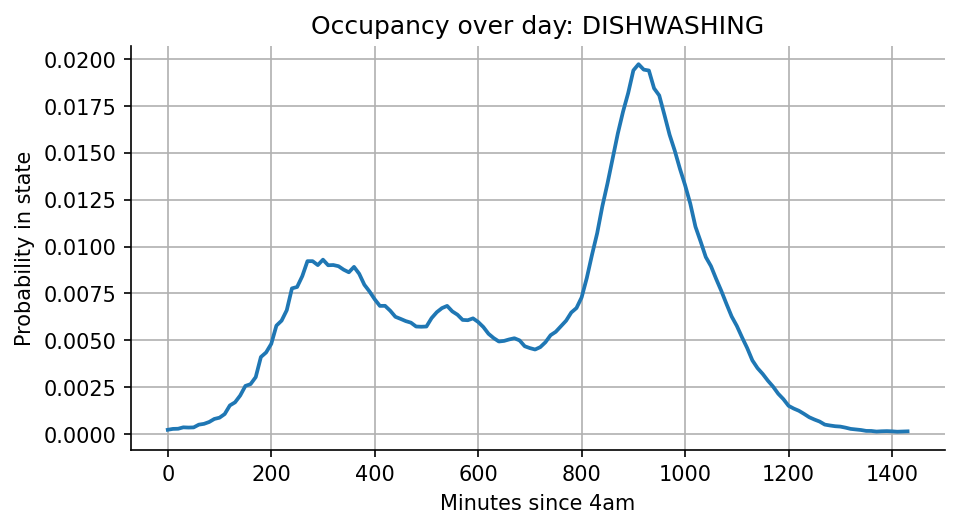

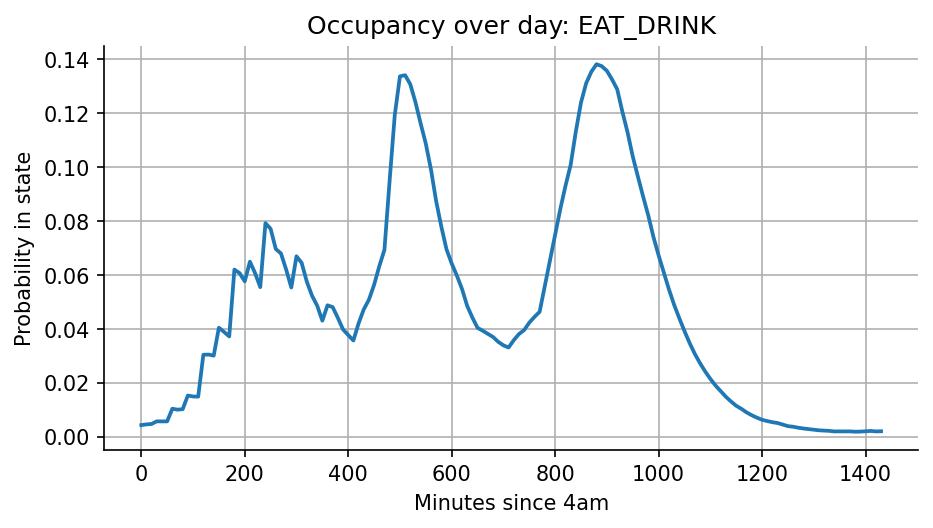

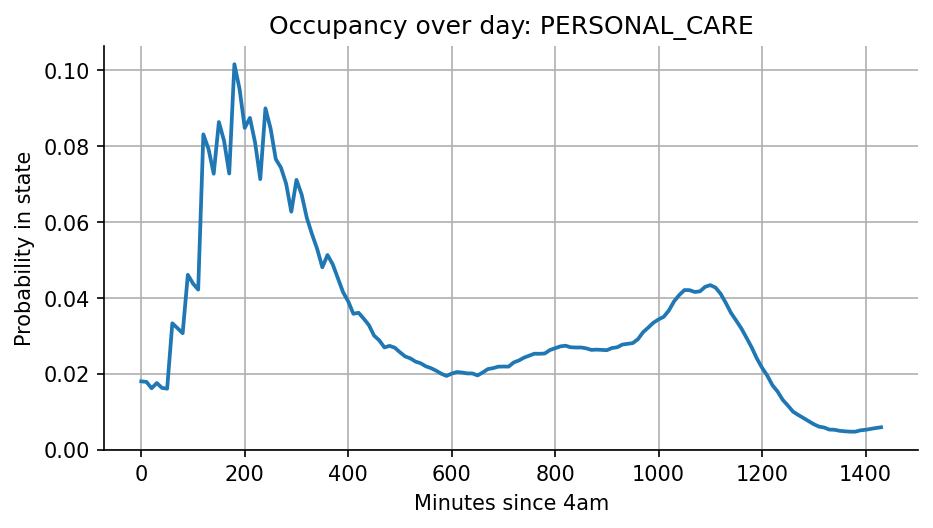

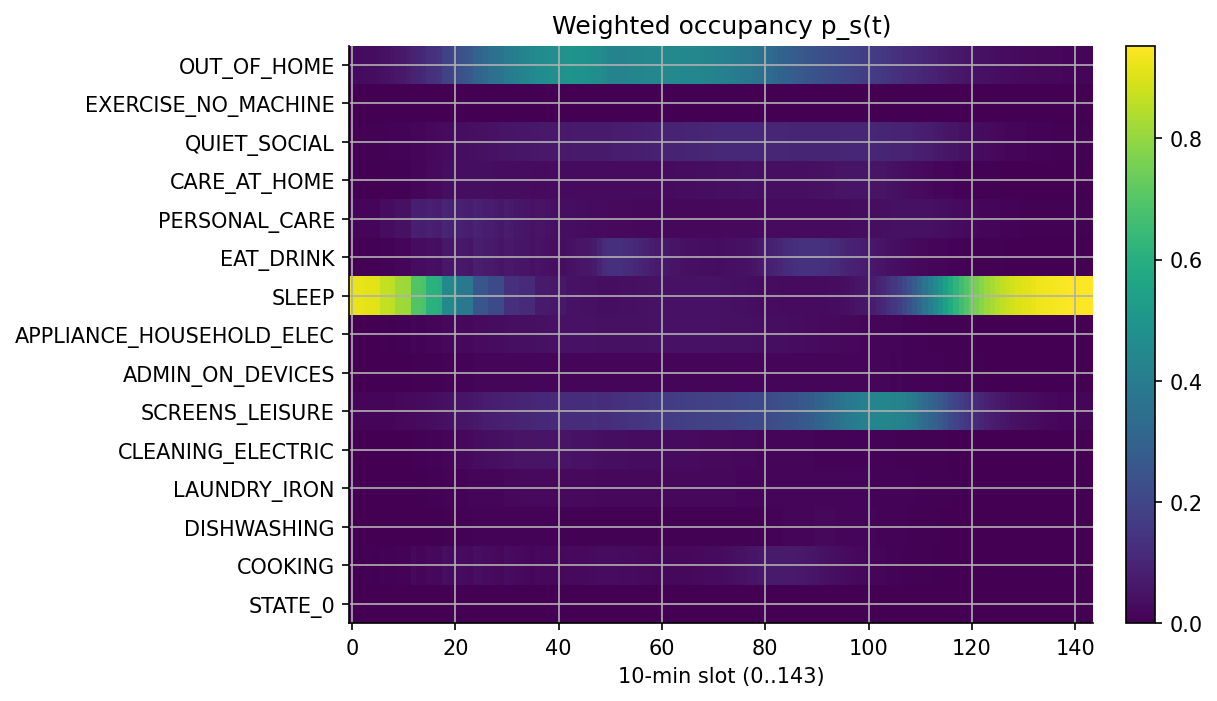

,state_id,state,share,minutes_per_day
8,8,SLEEP,0.345919,498.124070
14,14,OUT_OF_HOME,0.238828,343.912890
5,5,SCREENS_LEISURE,0.155677,224.174907
12,12,QUIET_SOCIAL,0.060121,86.573566
9,9,EAT_DRINK,0.048863,70.362172
10,10,PERSONAL_CARE,0.033546,48.305671
11,11,CARE_AT_HOME,0.025889,37.279754
7,7,APPLIANCE_HOUSEHOLD_ELEC,0.023407,33.706172
1,1,COOKING,0.021510,30.974415
4,4,CLEANING_ELECTRIC,0.017818,25.657693


In [ ]:
# overall occupancy curves + table
occ_all = weighted_occupancy(states, w, K)  # K x 144
minutes = slot_minutes()

# Pick some key states from your 14-taxonomy (edit names if needed)
KEY_STATES = [
    "SLEEP", "COOKING", "DISHWASHING", "LAUNDRY",
    "WORK_ENTERTAINMENT", "APPLIANCE_TOOL_USE",
    "EAT_DRINK", "PERSONAL_CARE", "SOCIAL_HOME", "OUTDOOR_EXERCISE",
    "WORK_SCHOOL", "TRAVEL", "ENTERTAINMENT_OUT"
]

key_ids = [sub_to_id[s] for s in KEY_STATES if s in sub_to_id]

# Plot occupancy curves for key states (probability over the day)
for sid in key_ids:
    fig, ax = plt.subplots()
    ax.plot(minutes, occ_all[sid], lw=1.8)
    ax.set_title(f"Occupancy over day: {label_for(sid)}")
    ax.set_xlabel("Minutes since 4am")
    ax.set_ylabel("Probability in state")
    plt.show()

# Heatmap of all states (optional)
fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(occ_all, aspect="auto", origin="lower", interpolation="nearest")
ax.set_yticks(np.arange(K))
ax.set_yticklabels([label_for(i) for i in range(K)])
ax.set_xlabel("10-min slot (0..143)")
ax.set_title("Weighted occupancy p_s(t)")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.show()

# Table: top time shares
tt = top_time_share(occ_all, top=min(10, K))
to_table(tt, "overall_top_time_share")
tt


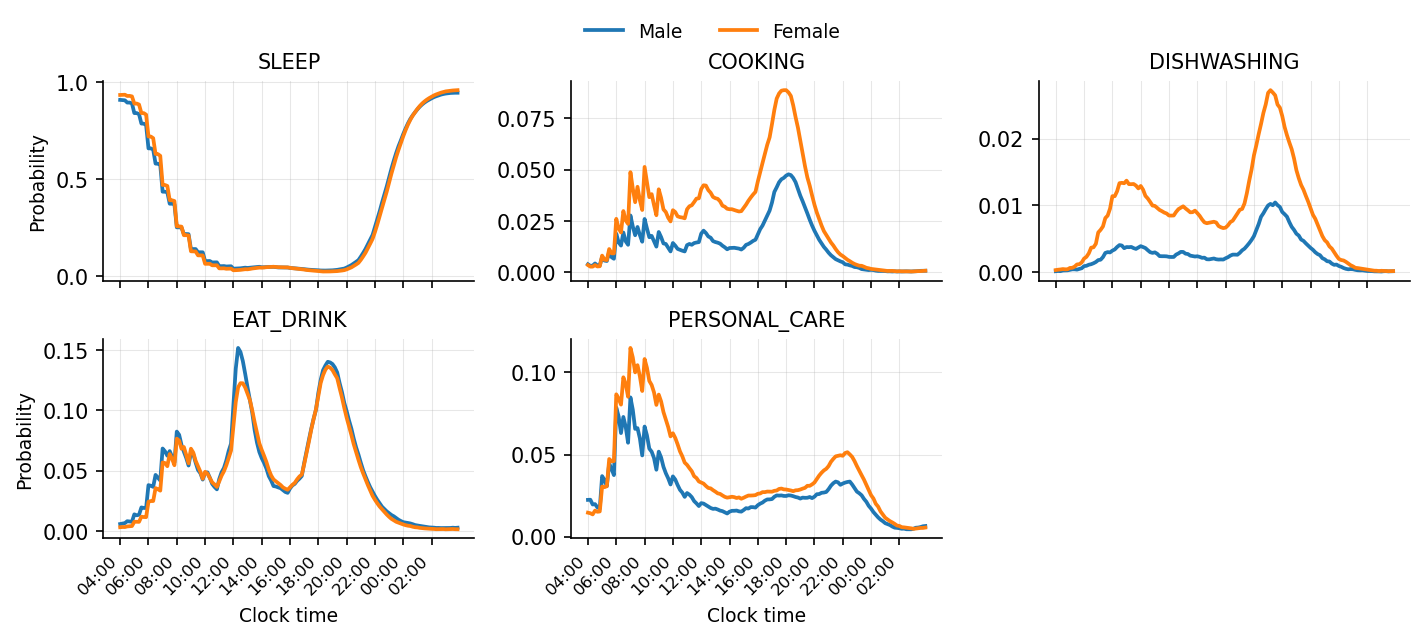

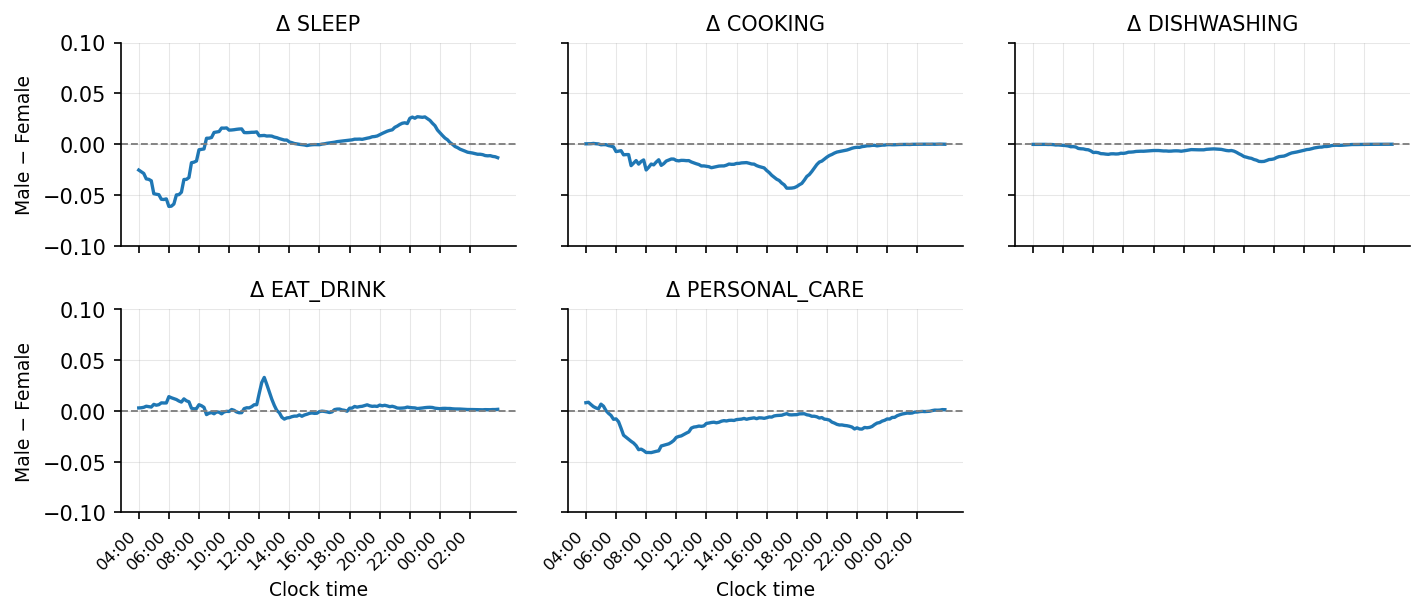

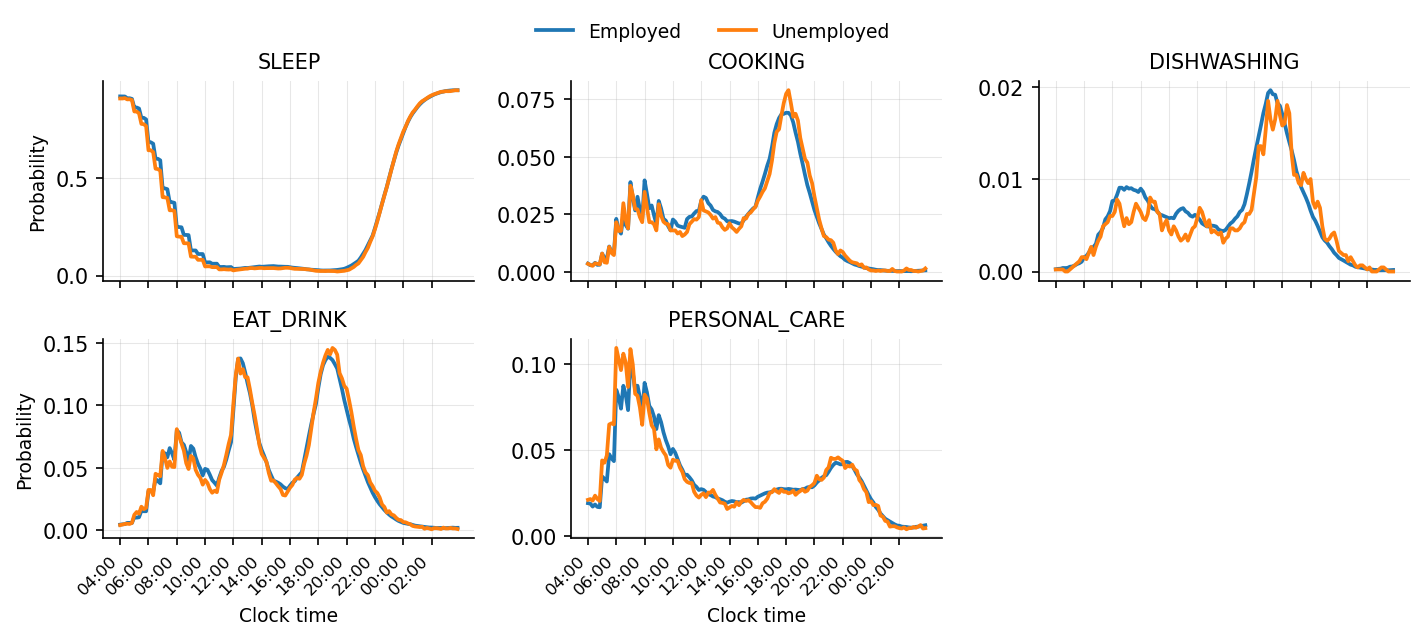

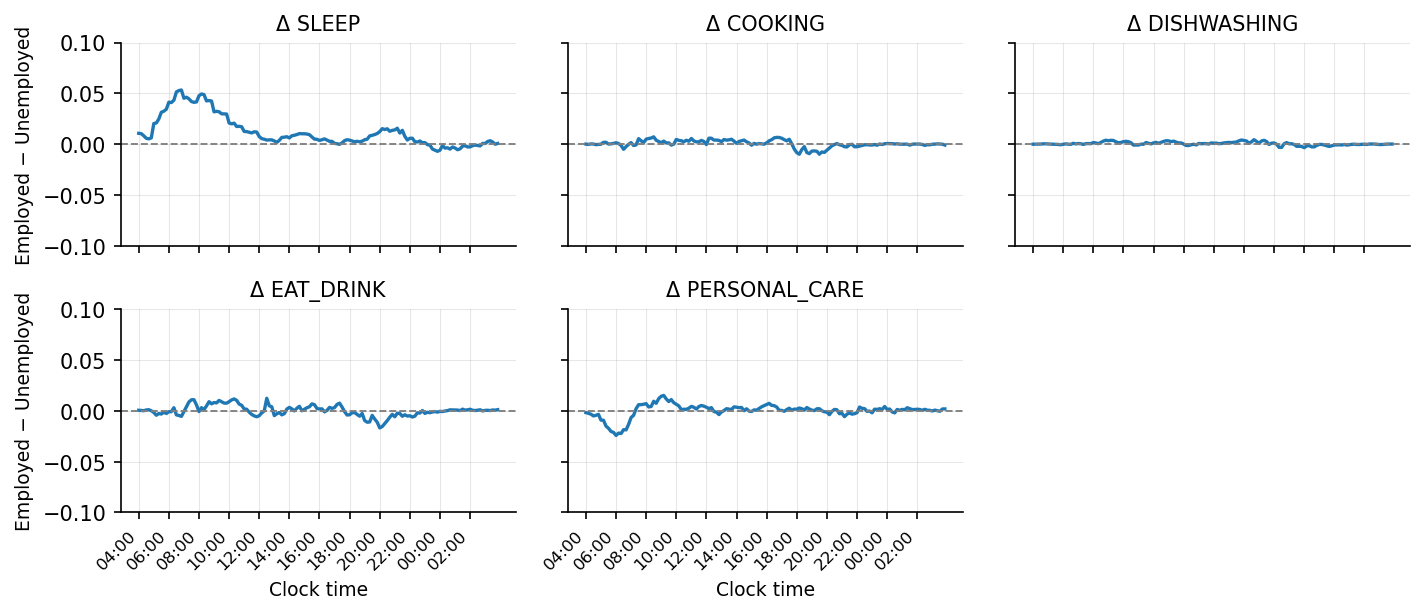

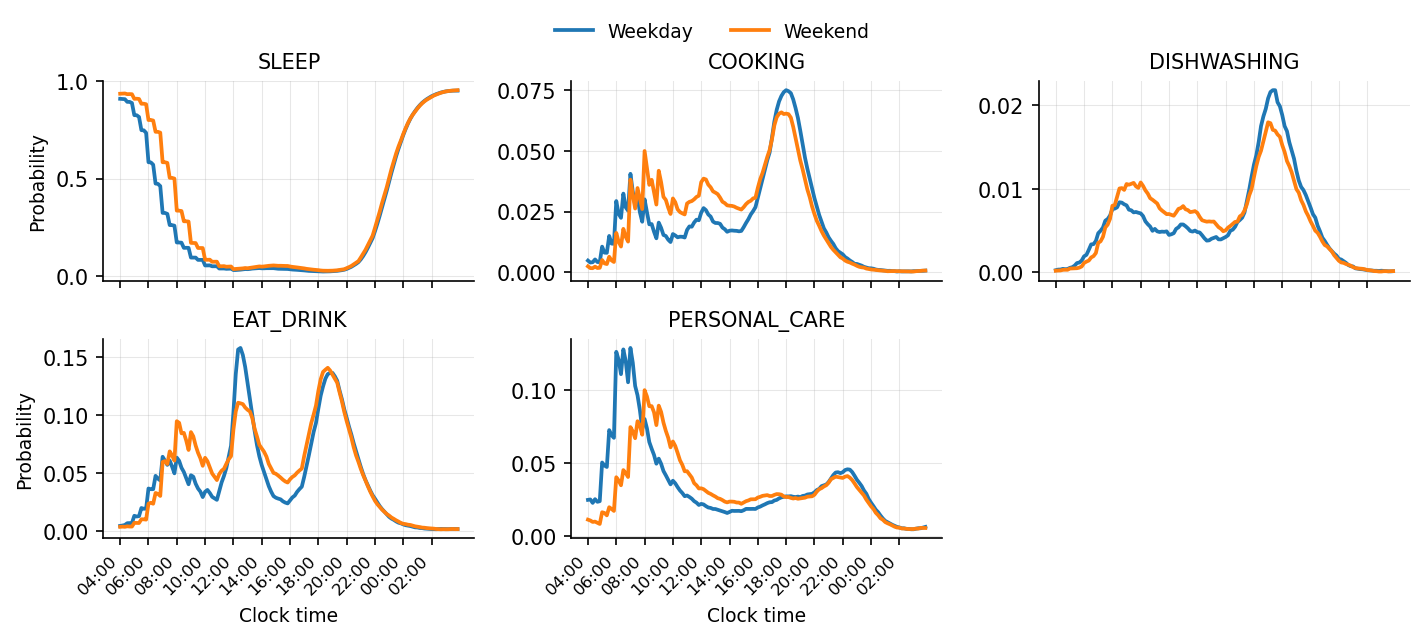

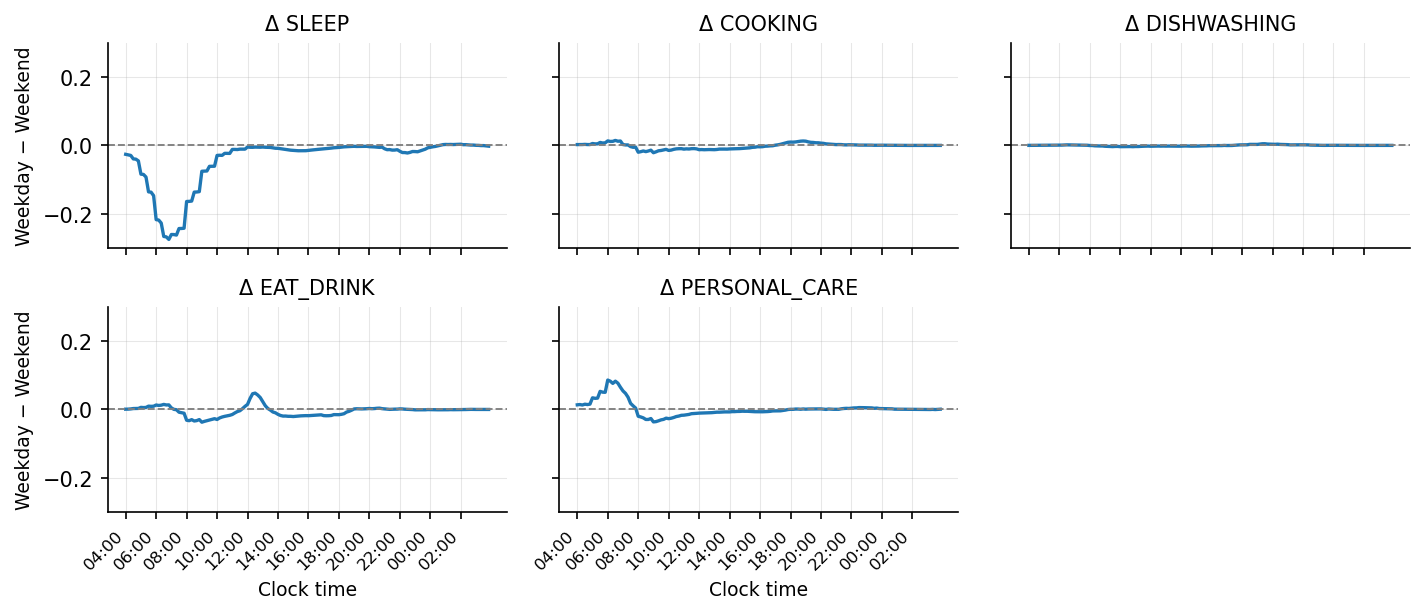

NameError: name 'prefix' is not defined

In [ ]:
sex_norm        = sex.astype("string").str.strip().str.lower()
employment_norm = employment.astype("string").str.strip().str.lower()
day_type_norm   = day_type.astype("string").str.strip().str.lower()

mask_m   = (sex_norm == "male").to_numpy(dtype=bool)
mask_f   = (sex_norm == "female").to_numpy(dtype=bool)

mask_emp = (employment_norm == "employed").to_numpy(dtype=bool)
mask_un  = (employment_norm == "unemployed").to_numpy(dtype=bool)

mask_wd  = (day_type_norm == "weekday").to_numpy(dtype=bool)
mask_we  = (day_type_norm == "weekend").to_numpy(dtype=bool)

# --- Helpers ------------------------------------------------------------------
def occ_by_mask(mask_bool: np.ndarray) -> np.ndarray:
    mask_bool = np.asarray(mask_bool, dtype=bool)
    if not mask_bool.any():
        return occ_all
    return weighted_occupancy(states[mask_bool], w[mask_bool], K)

def _label_for(sid: int) -> str:
    try:
        return label_for(sid)
    except Exception:
        return f"State {sid}"

def _hour_ticks(minutes):
    # 4am start → ticks every 2 hours
    hrs = np.arange(4, 28, 2)  # 4:00 … 26:00 (2am next day)
    xt = (hrs - 4) * 60
    xl = [f"{h%24:02d}:00" for h in hrs]
    return xt, xl

def _grid_shape(n):
    # Make a compact grid (<= 6 → 2 rows; else 3 rows)
    if n <= 4:  return 2, 2
    if n <= 6:  return 2, 3
    if n <= 9:  return 3, 3
    if n <= 12: return 3, 4
    return 4, int(np.ceil(n/4))

def plot_grid_and_diff(occ_a, occ_b, label_a, label_b, key_ids, minutes, prefix):
    Path("figures").mkdir(parents=True, exist_ok=True)
    n = len(key_ids)
    nrows, ncols = _grid_shape(n)
    xt, xl = _hour_ticks(minutes)

    # -------- Grid of curves (A vs B) --------
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.1*nrows), sharex=True, sharey=False)
    axes = np.atleast_1d(axes).ravel()

    for i, sid in enumerate(key_ids):
        ax = axes[i]
        ax.plot(minutes, occ_a[sid], lw=1.8, label=label_a)
        ax.plot(minutes, occ_b[sid], lw=1.8, label=label_b)
        ax.set_title(_label_for(sid), fontsize=10)
        ax.set_xticks(xt); ax.set_xticklabels(xl, rotation=45, ha="right", fontsize=8)
        ax.grid(alpha=0.3, linewidth=0.5)
        if i % ncols == 0:
            ax.set_ylabel("Probability", fontsize=9)
        if i // ncols == nrows - 1:
            ax.set_xlabel("Clock time", fontsize=9)

    # Hide any empty panels
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    # Single legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, ncols=2, loc="upper center", bbox_to_anchor=(0.5, 1.02), frameon=False, fontsize=9)
    fig.tight_layout(rect=[0, 0, 1, 0.98])
    fig.savefig(f"figures/{prefix}_curves.png", dpi=700)
    plt.show()

    # -------- Grid of differences (A − B) --------
    # Symmetric y-lims across all subplots for comparability
    max_abs = 0.0
    diffs = []
    for sid in key_ids:
        d = occ_a[sid] - occ_b[sid]
        diffs.append(d)
        max_abs = max(max_abs, np.max(np.abs(d)))
    ylim = max(0.05, np.ceil(max_abs*20)/20)  # round up to nearest 0.05

    fig, axes = plt.subplots(nrows, ncols, figsize=(3.2*ncols, 2.1*nrows), sharex=True, sharey=True)
    axes = np.atleast_1d(axes).ravel()

    for i, (sid, d) in enumerate(zip(key_ids, diffs)):
        ax = axes[i]
        ax.plot(minutes, d, lw=1.6)
        ax.axhline(0, ls="--", lw=0.9, color="gray")
        ax.set_ylim(-ylim, ylim)
        ax.set_title(f"Δ { _label_for(sid) }", fontsize=10)
        ax.set_xticks(xt); ax.set_xticklabels(xl, rotation=45, ha="right", fontsize=8)
        ax.grid(alpha=0.3, linewidth=0.5)
        if i % ncols == 0:
            ax.set_ylabel(f"{label_a} − {label_b}", fontsize=9)
        if i // ncols == nrows - 1:
            ax.set_xlabel("Clock time", fontsize=9)

    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    fig.tight_layout()
    fig.savefig(f"figures/{prefix}_diff.png", dpi=700)
    plt.show()

# --- Compute occupancies for comparisons --------------------------------------
occ_m   = occ_by_mask(mask_m)
occ_f   = occ_by_mask(mask_f)
occ_emp = occ_by_mask(mask_emp)
occ_un  = occ_by_mask(mask_un)
occ_wd  = occ_by_mask(mask_wd)
occ_we  = occ_by_mask(mask_we)

# --- Plot & save (dpi=700) ----------------------------------------------------
plot_grid_and_diff(occ_m,   occ_f,   "Male",      "Female",    key_ids, minutes, prefix="occ_sex")
plot_grid_and_diff(occ_emp, occ_un,  "Employed",  "Unemployed",key_ids, minutes, prefix="occ_employment")
plot_grid_and_diff(occ_wd,  occ_we,  "Weekday",   "Weekend",   key_ids, minutes, prefix="occ_daytype")

# fig.savefig(f"figures/{prefix}_curves.pdf")
# fig.savefig(f"figures/{prefix}_diff.pdf")


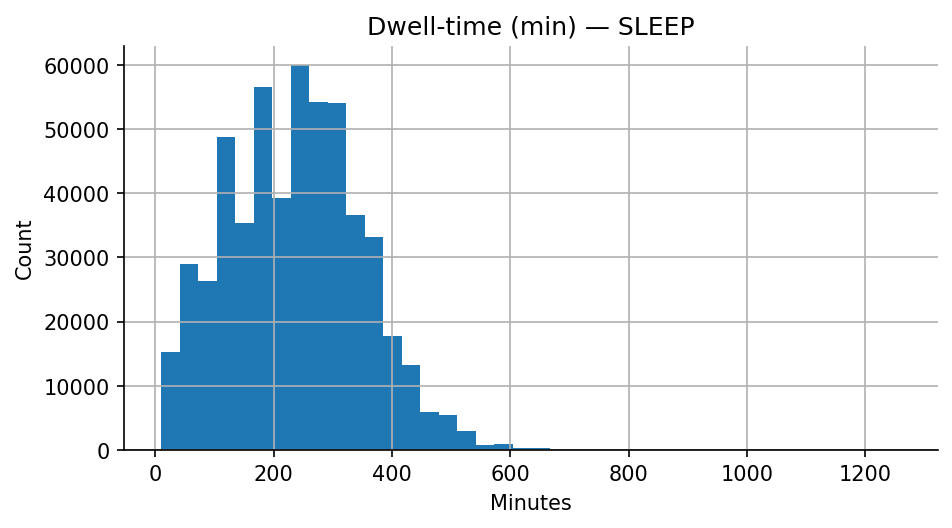

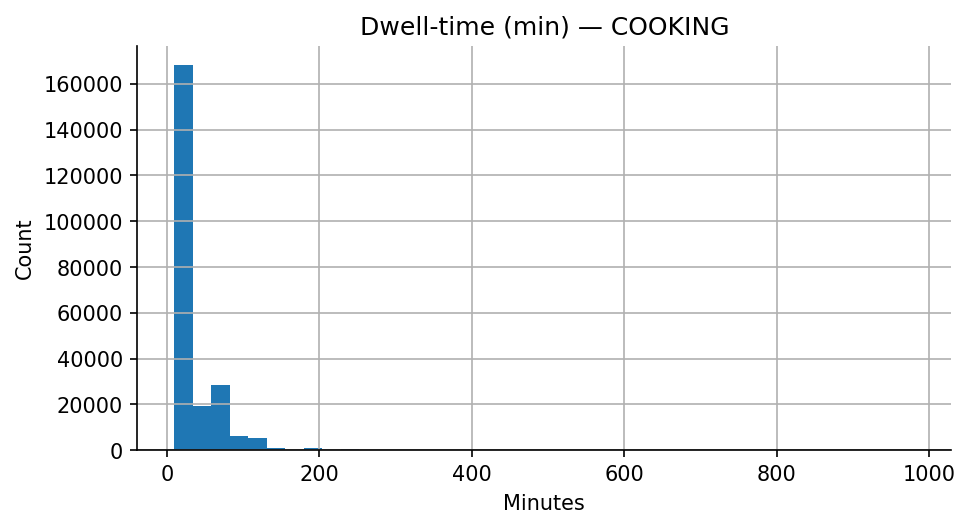

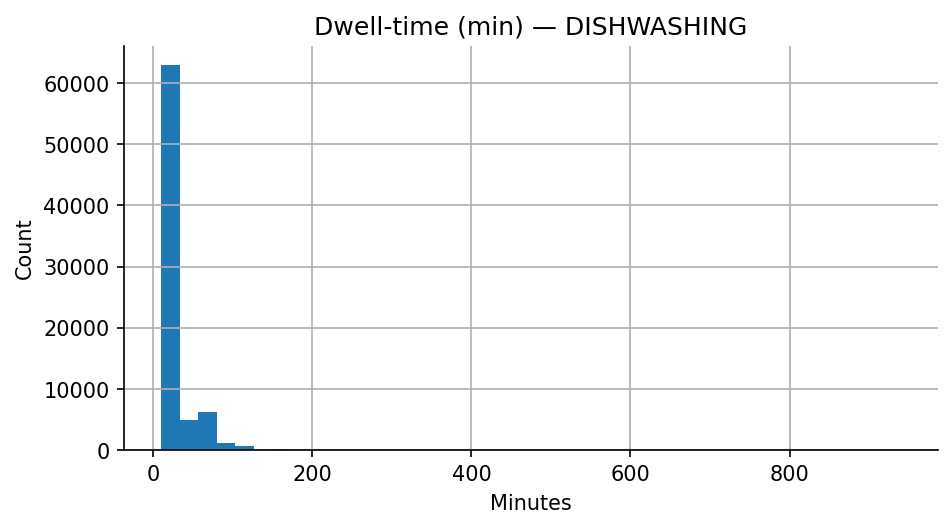

In [ ]:
# dwell-time histograms for key at-home states
# Each slot is 10 minutes; convert to minutes in labels.

DWELL_STATES = ["SLEEP", "WORK_ENTERTAINMENT", "COOKING", "DISHWASHING", "LAUNDRY"]
for name in DWELL_STATES:
    if name not in sub_to_id:
        continue
    sid = sub_to_id[name]
    runs = dwell_time_samples(states, sid)   # in slots
    if len(runs) == 0:
        continue
    durations_min = np.array(runs) * 10
    fig, ax = plt.subplots()
    ax.hist(durations_min, bins=40)
    ax.set_title(f"Dwell-time (min) — {name}")
    ax.set_xlabel("Minutes")
    ax.set_ylabel("Count")
    plt.show()


In [ ]:
# share-of-day tables per subgroup (for paper)
def share_table(occ, label):
    df = pd.DataFrame({
        "state_id": np.arange(K),
        "state": [label_for(i) for i in range(K)],
        "share": occ.mean(axis=1),
        "minutes_per_day": occ.mean(axis=1) * 144 * 10
    }).sort_values("share", ascending=False)
    to_table(df, f"time_share_{label}")
    return df

share_table(occ_all, "overall")

if mask_m.any(): share_table(occ_m, "male")
if mask_f.any(): share_table(occ_f, "female")
if mask_emp.any(): share_table(occ_emp, "employed")
if mask_un.any(): share_table(occ_un, "unemployed")
if mask_wd.any(): share_table(occ_wd, "weekday")
if mask_we.any(): share_table(occ_we, "weekend")


In [ ]:
#  sanity checks and quick facts to cite
print("Weighted average minutes/day by state (overall):")
overall_minutes = (occ_all.mean(axis=1) * 144 * 10)
quick = pd.Series(overall_minutes, index=[label_for(i) for i in range(K)]).sort_values(ascending=False)
print(quick.head(15))

# Example: total OUT_OF_HOME share (if you want to aggregate majors)
sub_to_major = catalog.get("sub_to_major", {})
maj = pd.Series([sub_to_major.get(label_for(i), "UNKNOWN") for i in range(K)], index=np.arange(K))
out_mask = (maj == "OUT_OF_HOME").to_numpy()
out_share = occ_all[out_mask].sum(axis=0).mean()
print(f"Average OUT_OF_HOME share of day: {out_share:.3f} ({out_share*144*10:.1f} minutes)")


Weighted average minutes/day by state (overall):
SLEEP                       498.124070
OUT_OF_HOME                 343.912890
SCREENS_LEISURE             224.174907
QUIET_SOCIAL                 86.573566
EAT_DRINK                    70.362172
PERSONAL_CARE                48.305671
CARE_AT_HOME                 37.279754
APPLIANCE_HOUSEHOLD_ELEC     33.706172
COOKING                      30.974415
CLEANING_ELECTRIC            25.657693
LAUNDRY_IRON                 17.133358
ADMIN_ON_DEVICES             14.351642
DISHWASHING                   8.683270
EXERCISE_NO_MACHINE           0.760419
STATE_0                       0.000000
dtype: float64
Average OUT_OF_HOME share of day: 0.239 (343.9 minutes)


Occurrences of state 0 in states_10min.npy: 0
Max probability in R: 0.976025 (should be ≤ 1)
✓ All non-empty rows sum to ~1


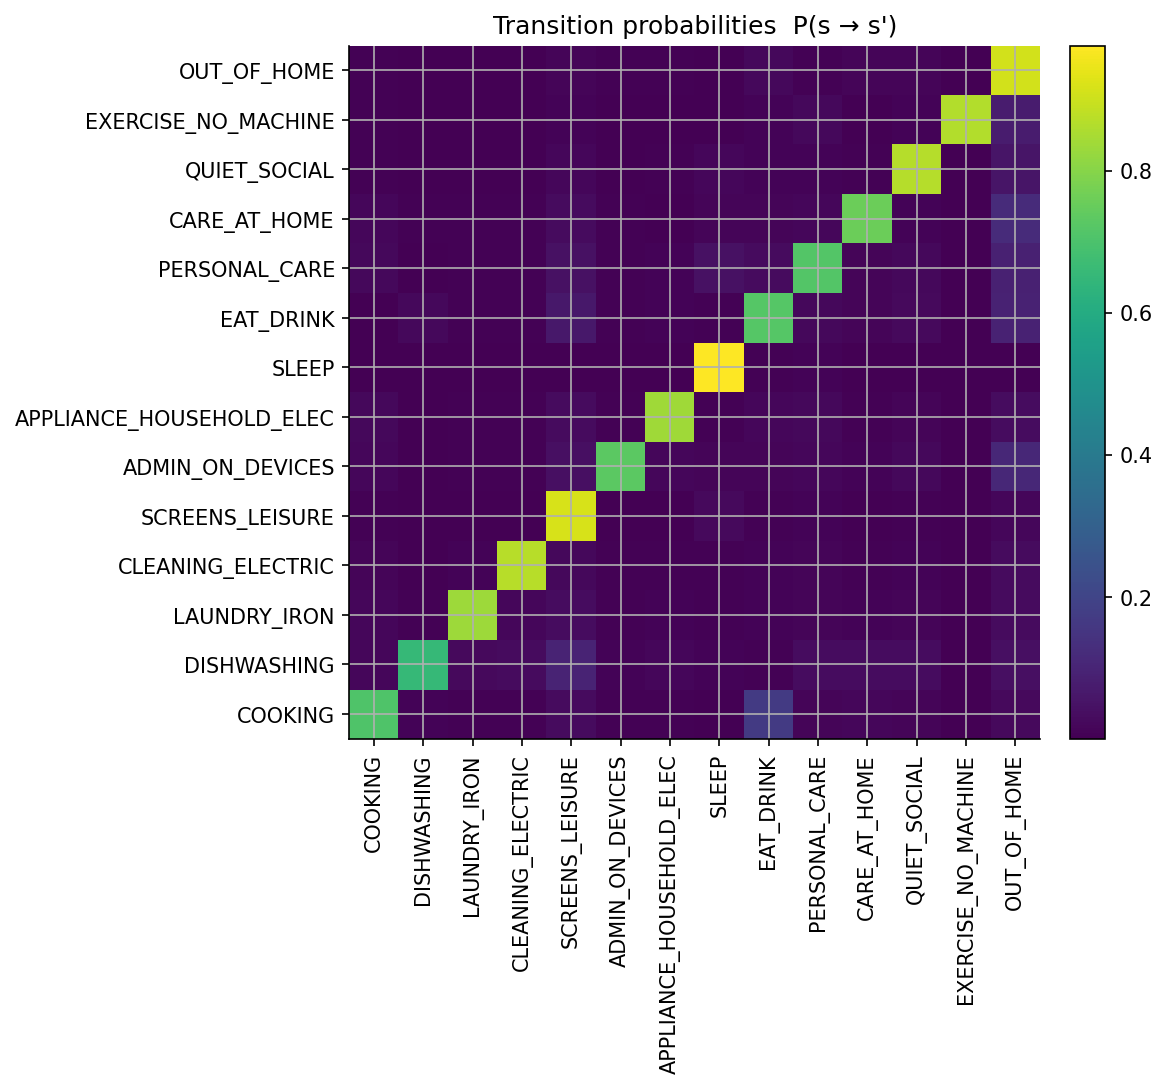

,from,to,p
0,COOKING,EAT_DRINK,0.165605
1,CARE_AT_HOME,OUT_OF_HOME,0.121115
2,ADMIN_ON_DEVICES,OUT_OF_HOME,0.107728
3,DISHWASHING,SCREENS_LEISURE,0.097766
4,EAT_DRINK,OUT_OF_HOME,0.095313
5,PERSONAL_CARE,OUT_OF_HOME,0.089356
6,EXERCISE_NO_MACHINE,OUT_OF_HOME,0.074475
7,EAT_DRINK,SCREENS_LEISURE,0.064241
8,QUIET_SOCIAL,OUT_OF_HOME,0.054623
9,PERSONAL_CARE,SCREENS_LEISURE,0.043745


In [ ]:
# --- Robust weighted transition matrix (excludes state 0) ---

# 1) Sanity: do we have any zeros in the states array?
ZERO_ID = 0
zero_count = int((states == ZERO_ID).sum())
print(f"Occurrences of state 0 in states_10min.npy: {zero_count:,}")

# 2) Use only the IDs we actually use in the taxonomy, excluding 0
#    Prefer catalog if available; otherwise infer from data
try:
    # If you have ID_TO_SUB in memory / from catalog
    id_list = sorted([sid for sid in ID_TO_SUB.keys() if sid != ZERO_ID])
    labels  = [ID_TO_SUB[sid] for sid in id_list]
except Exception:
    # Fallback: infer from data
    id_list = sorted([sid for sid in np.unique(states) if sid != ZERO_ID])
    labels  = [label_for(sid) for sid in id_list]

K_eff = len(id_list)
max_sid = int(np.max(id_list)) if len(id_list) else 0

# 3) Build a fast lookup from original state-id -> compact row/col index
lut = -np.ones(max_sid + 1, dtype=np.int32)
lut[np.array(id_list, dtype=np.int32)] = np.arange(K_eff, dtype=np.int32)

# 4) Accumulate weighted transition counts (exclude transitions involving 0)
C = np.zeros((K_eff, K_eff), dtype=float)
N, S = states.shape
for n in range(N):
    s = states[n]
    wn = float(w[n] if "w" in locals() else 1.0)
    src = s[:-1]
    dst = s[1:]
    valid = (src != ZERO_ID) & (dst != ZERO_ID)
    if not np.any(valid):
        continue
    src_idx = lut[src[valid]]
    dst_idx = lut[dst[valid]]
    # in case any -1 slipped in (shouldn't), drop them
    ok = (src_idx >= 0) & (dst_idx >= 0)
    if not np.any(ok):
        continue
    np.add.at(C, (src_idx[ok], dst_idx[ok]), wn)

# 5) Row-normalize to probabilities
R = C.copy()
row_sums = R.sum(axis=1, keepdims=True)
with np.errstate(invalid="ignore", divide="ignore"):
    R = np.where(row_sums > 0, R / row_sums, 0.0)

# 6) Quick sanity checks
print(f"Max probability in R: {R.max():.6f} (should be ≤ 1)")
row_invalid = np.where((row_sums.squeeze() > 0) & (np.abs(R.sum(axis=1) - 1) > 1e-8))[0]
if len(row_invalid):
    print("Rows not summing to ~1:", row_invalid.tolist())
else:
    print("All non-empty rows sum to ~1")

# 7) Save matrices (with clean labels)
idx = labels
pd.DataFrame(C, index=idx, columns=idx).to_csv(TAB_DIR / "transition_counts_weighted.csv")
pd.DataFrame(R, index=idx, columns=idx).to_csv(TAB_DIR / "transition_probs_weighted.csv")

# 8) Heatmap (probabilities)
fig, ax = plt.subplots(figsize=(6.5, 6))
im = ax.imshow(R, origin="lower", interpolation="nearest", aspect="auto")
ax.set_xticks(np.arange(K_eff)); ax.set_xticklabels(idx, rotation=90)
ax.set_yticks(np.arange(K_eff)); ax.set_yticklabels(idx)
ax.set_title("Transition probabilities  P(s → s')")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
fig.savefig(OUT_DIR / "transition_probs_heatmap.png", dpi=700, bbox_inches="tight")
plt.show()

# 9) Top transitions (exclude self)
pairs = []
for i in range(K_eff):
    for j in range(K_eff):
        if i == j:
            continue
        p = R[i, j]
        if p > 0:
            pairs.append((labels[i], labels[j], float(p)))

top_pairs = (pd.DataFrame(pairs, columns=["from", "to", "p"])
               .sort_values("p", ascending=False)
               .head(25)
               .reset_index(drop=True))

# Save + display
top_pairs.to_csv(TAB_DIR / "top_transitions_weighted.csv", index=False)
display(top_pairs.head(10))

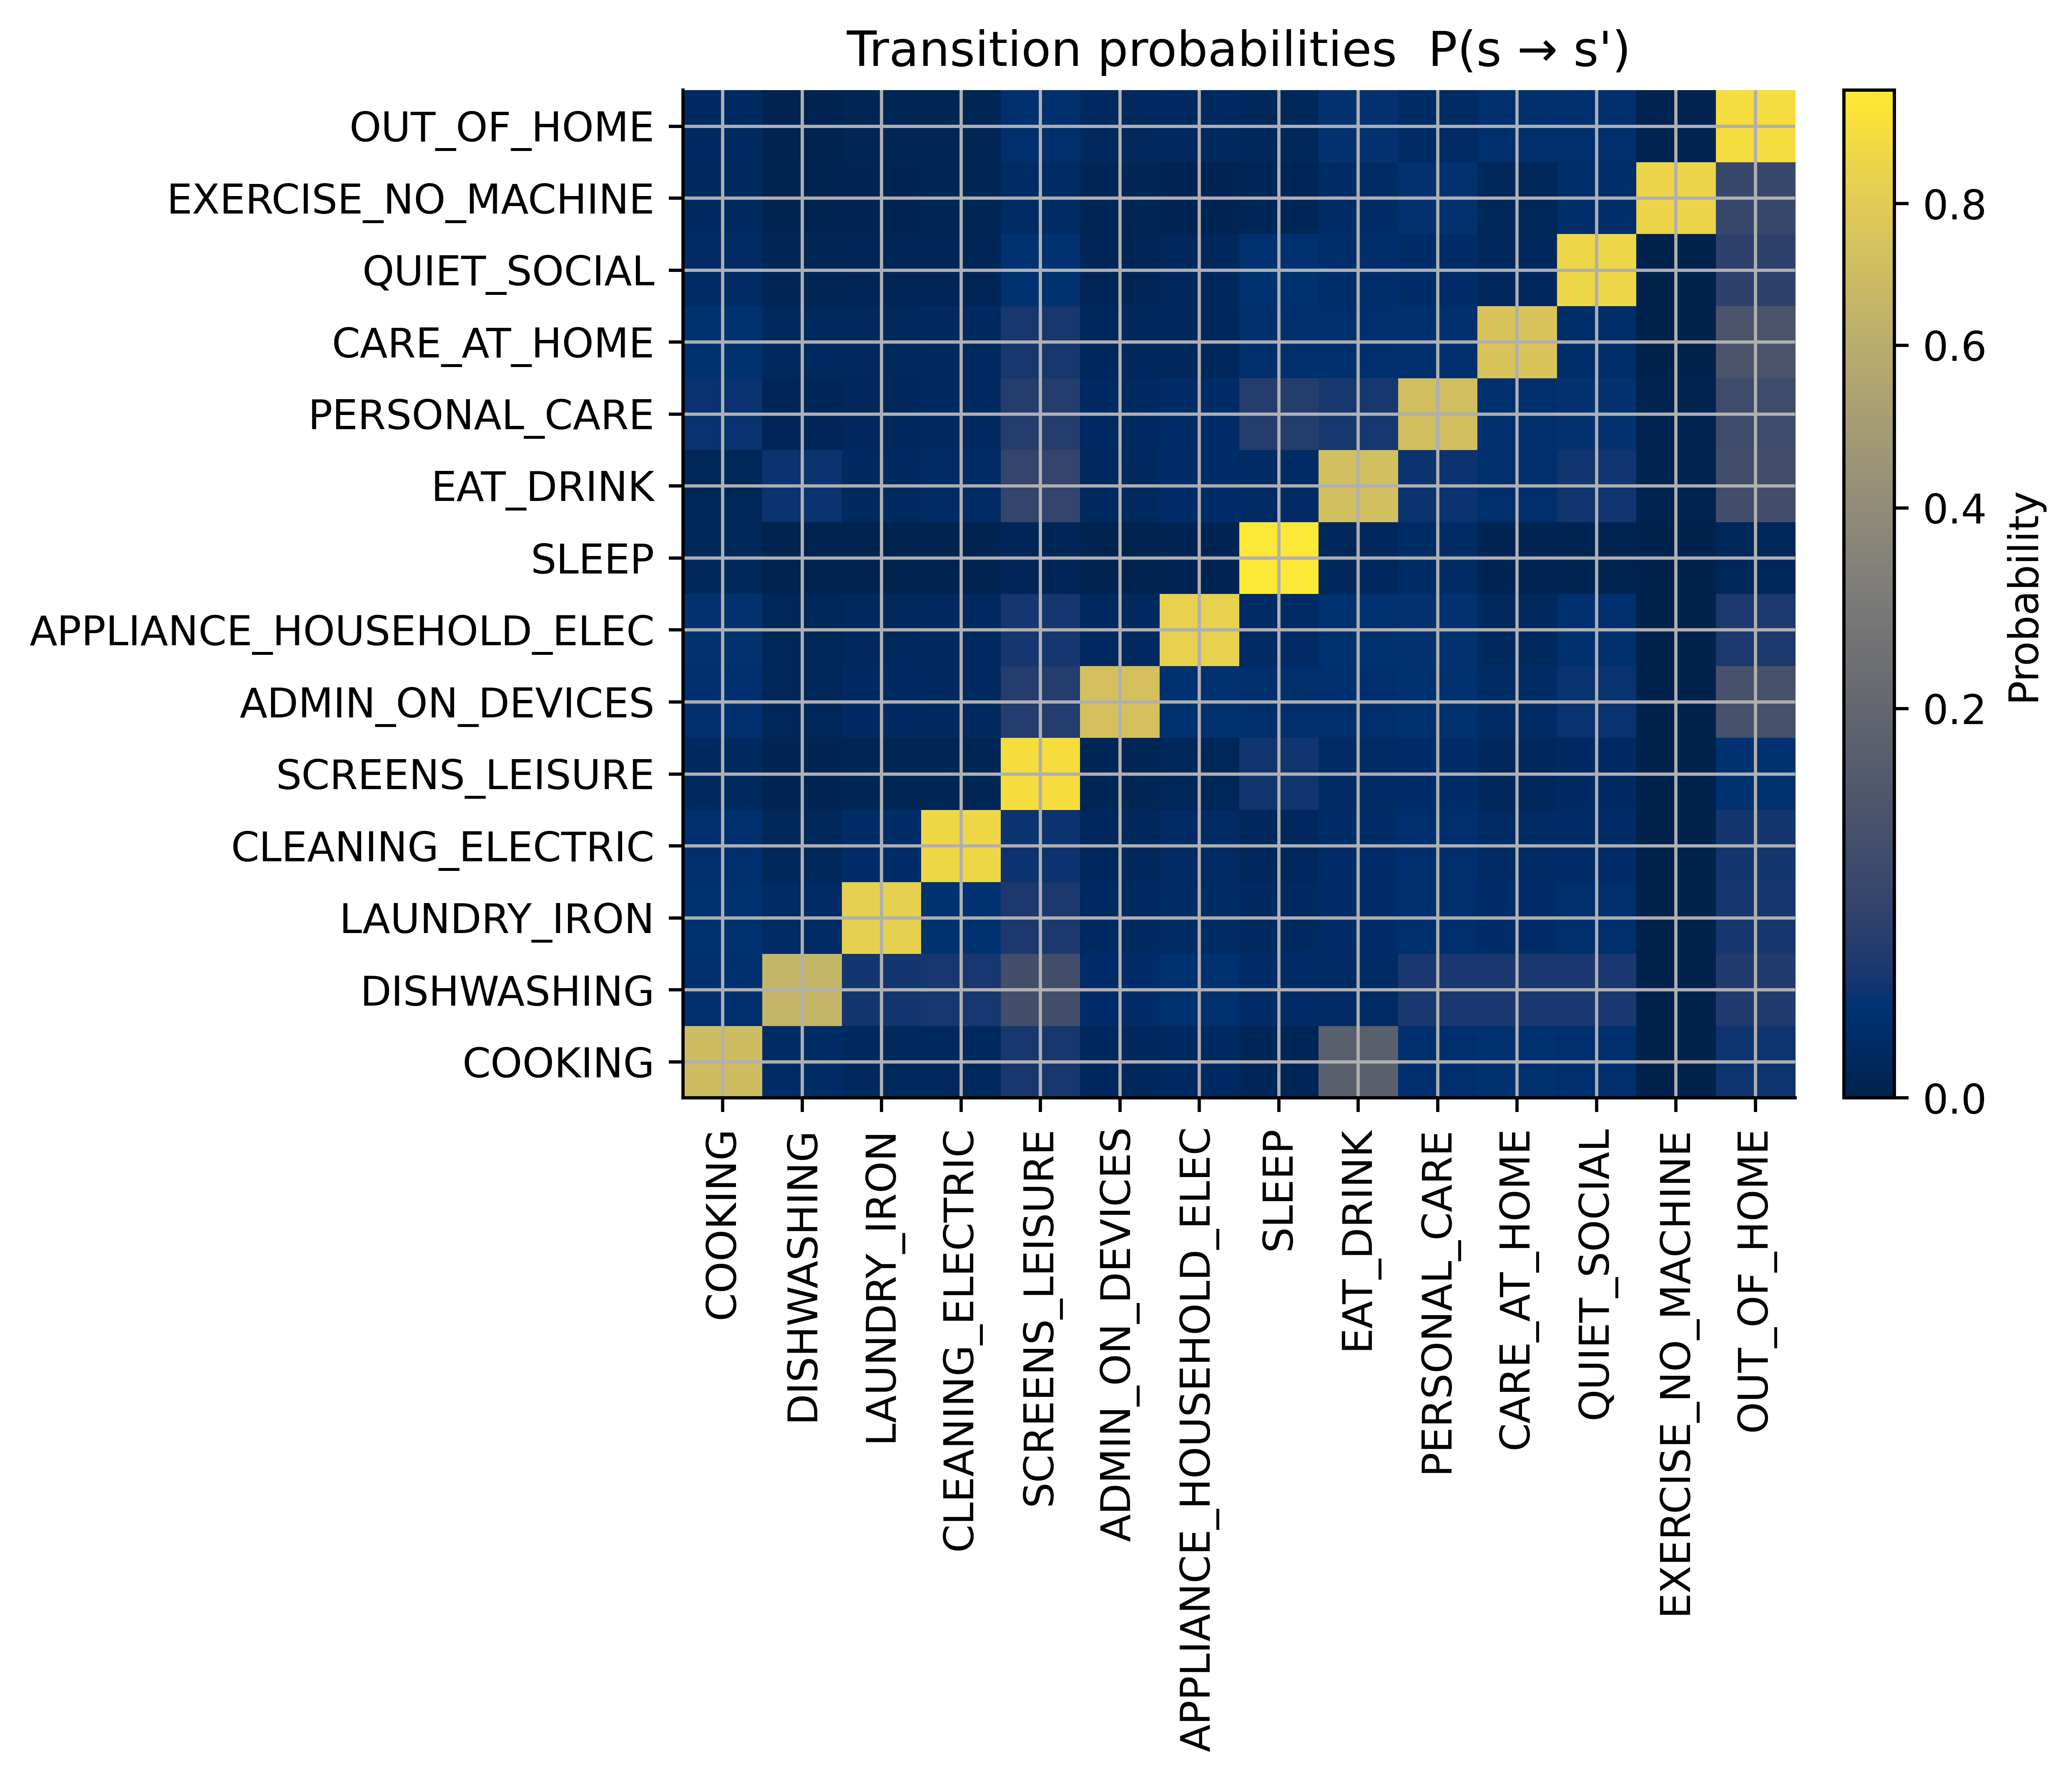

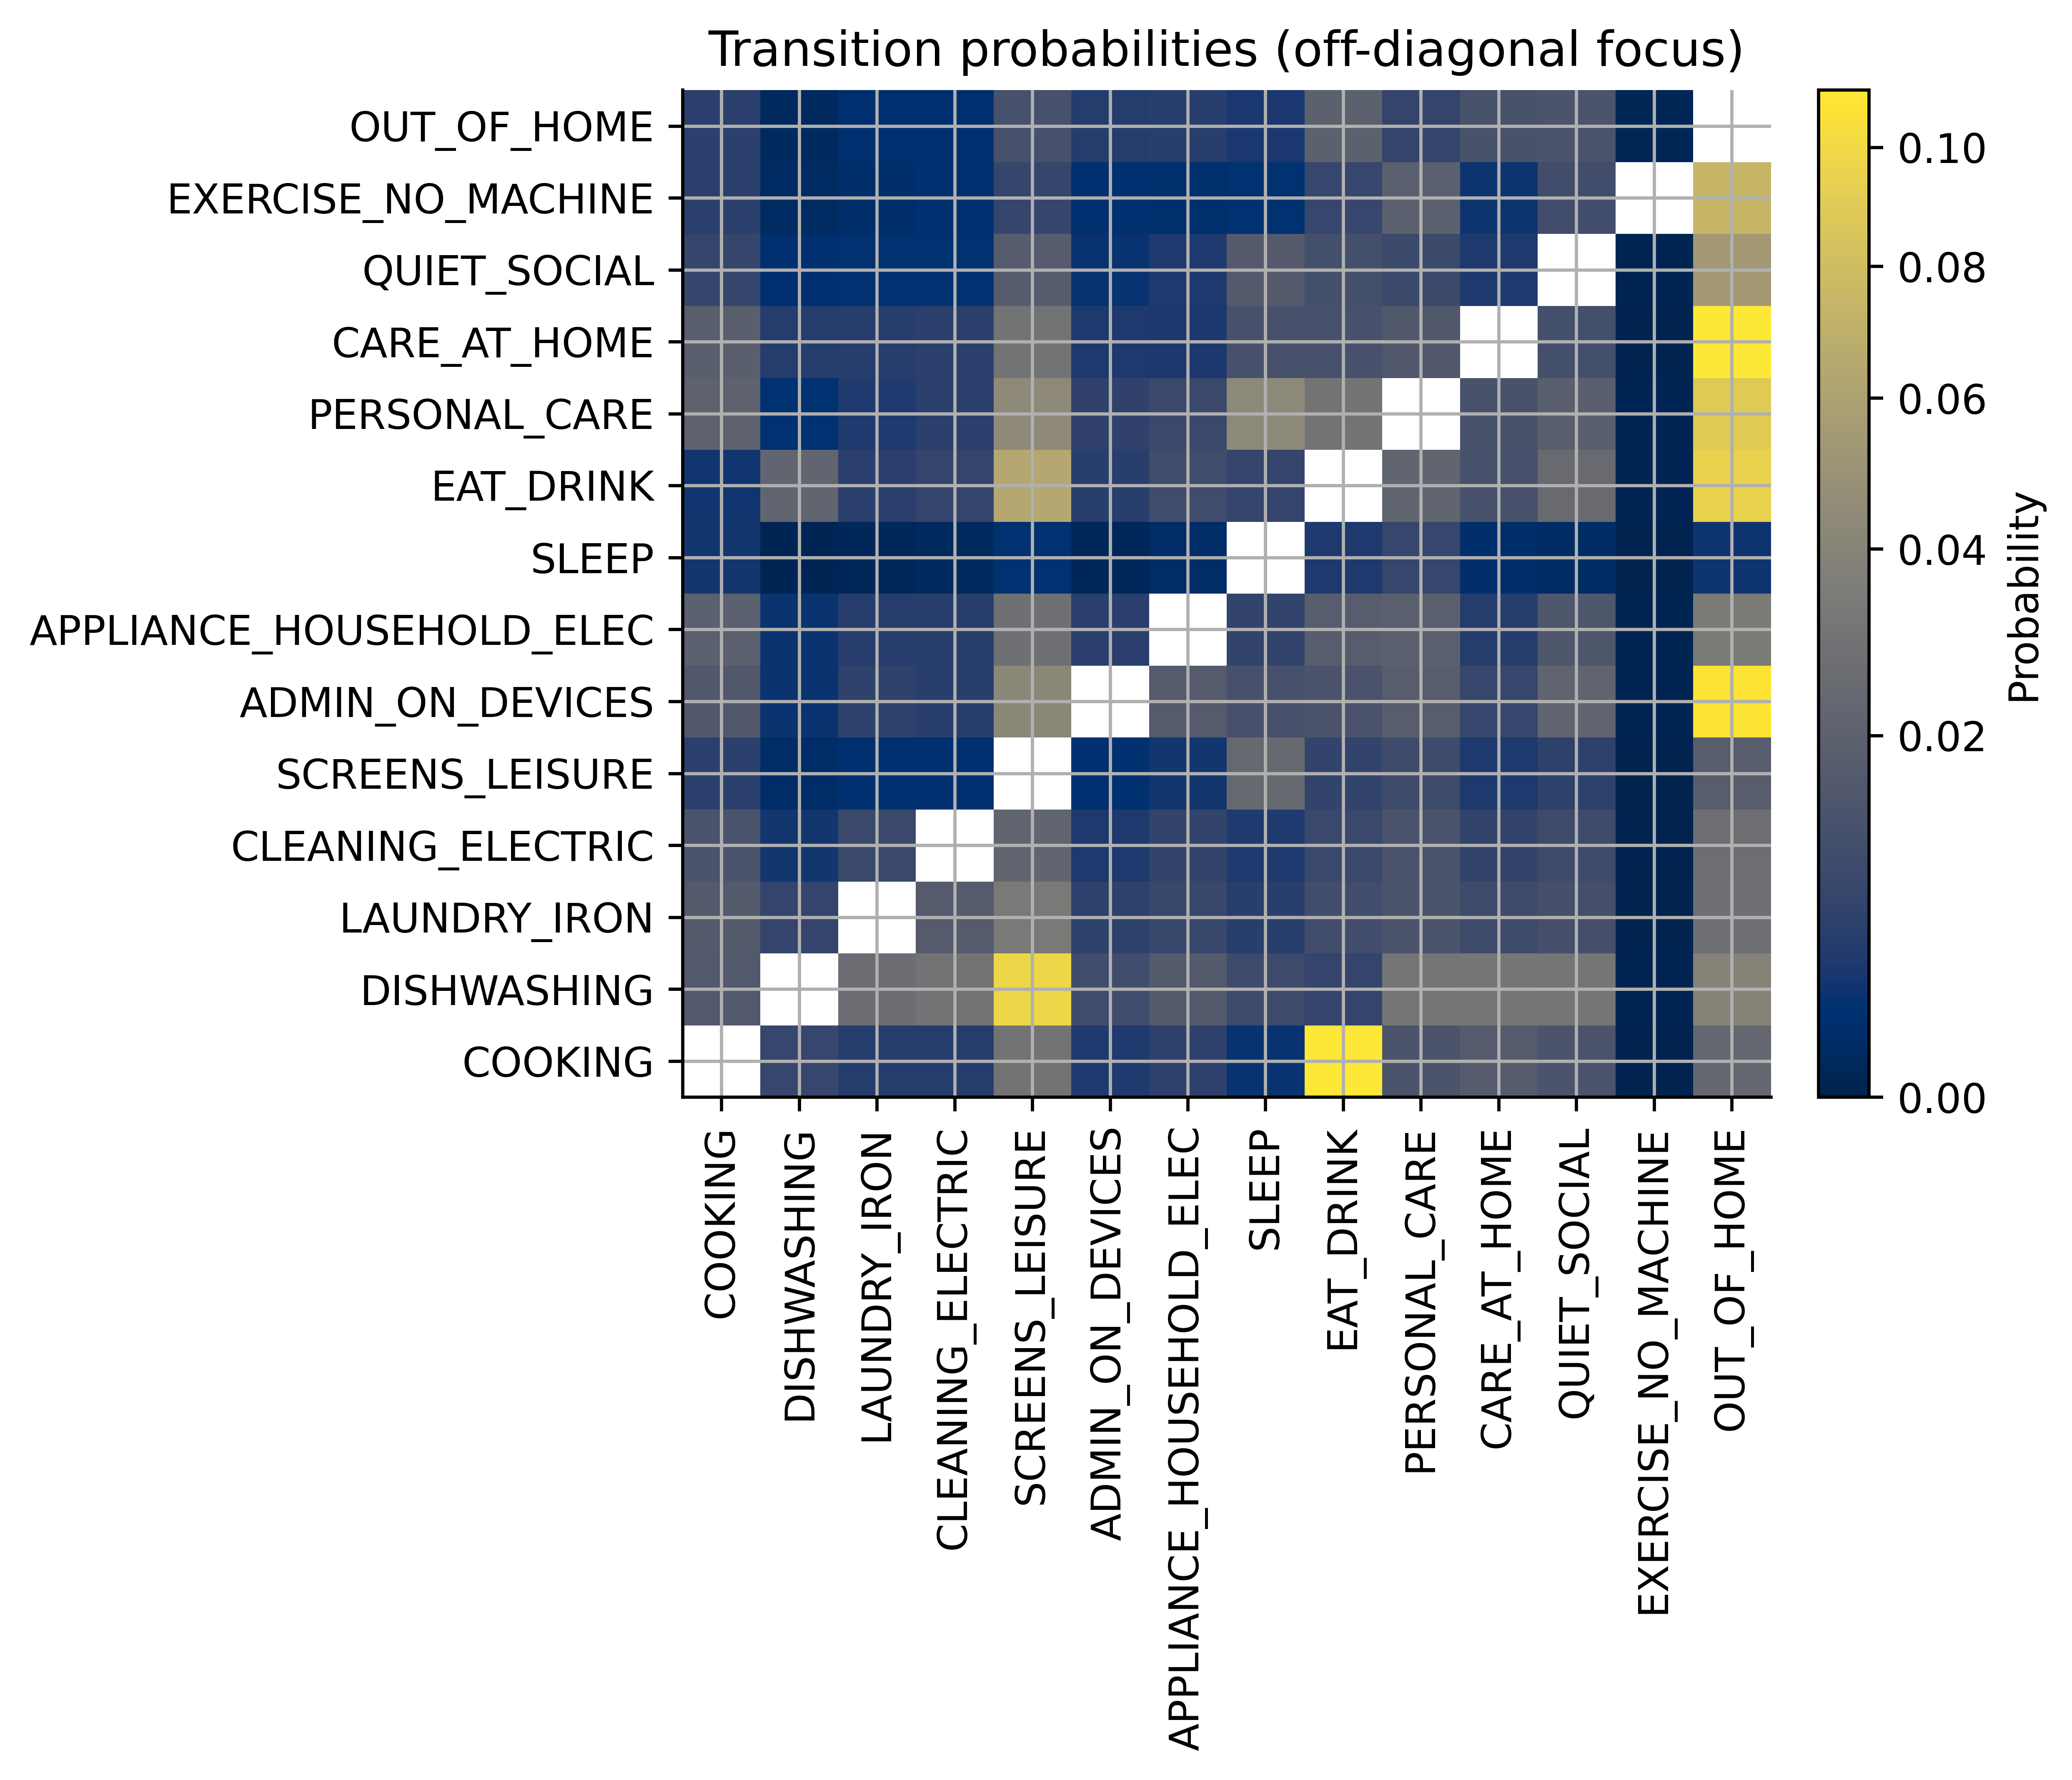

In [ ]:
# 1) Full matrix (keep diagonal), perceptually uniform colormap + gamma correction
fig, ax = plt.subplots(figsize=(7.2, 6.2), dpi=700)
im = ax.imshow(
    R, origin="lower", aspect="auto",
    cmap="cividis", norm=PowerNorm(gamma=0.6, vmin=0, vmax=R.max() if np.isfinite(R).all() else 1)
)
ax.set_xticks(np.arange(len(labels))); ax.set_xticklabels(labels, rotation=90)
ax.set_yticks(np.arange(len(labels))); ax.set_yticklabels(labels)
ax.set_title("Transition probabilities  P(s → s')")
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Probability", rotation=90)
fig.tight_layout()
fig.savefig(OUT_DIR / "transition_probs_heatmap_cividis.png", bbox_inches="tight")

plt.show()

# 2) Off-diagonal zoom (hide self-loops so smaller off-diagonals are visible)
R_off = R.copy()
np.fill_diagonal(R_off, np.nan)  # mask diagonals for scaling
vmax = np.nanpercentile(R_off, 99)  # robust upper bound for better contrast

fig, ax = plt.subplots(figsize=(7.2, 6.2), dpi=700)
im = ax.imshow(
    R_off, origin="lower", aspect="auto",
    cmap="cividis", norm=PowerNorm(gamma=0.6, vmin=0, vmax=vmax)
)
ax.set_xticks(np.arange(len(labels))); ax.set_xticklabels(labels, rotation=90)
ax.set_yticks(np.arange(len(labels))); ax.set_yticklabels(labels)
ax.set_title("Transition probabilities (off-diagonal focus)")
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Probability", rotation=90)
fig.tight_layout()
fig.savefig(OUT_DIR / "transition_probs_heatmap_offdiag_cividis.png", bbox_inches="tight")

plt.show()

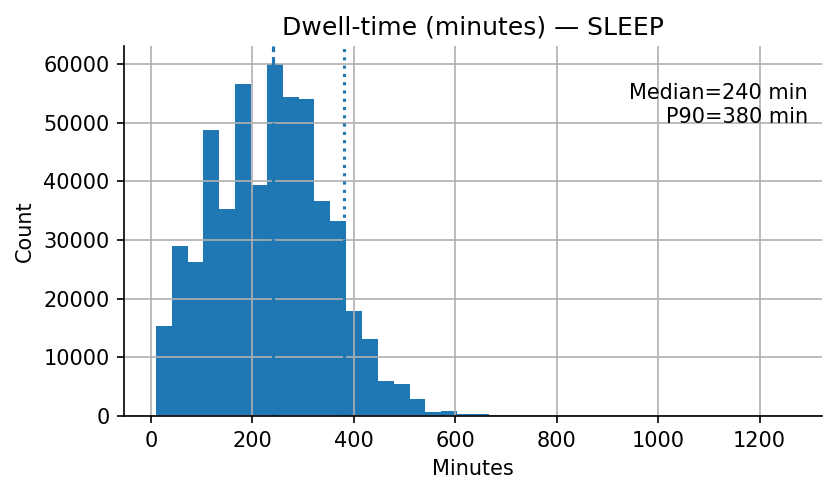

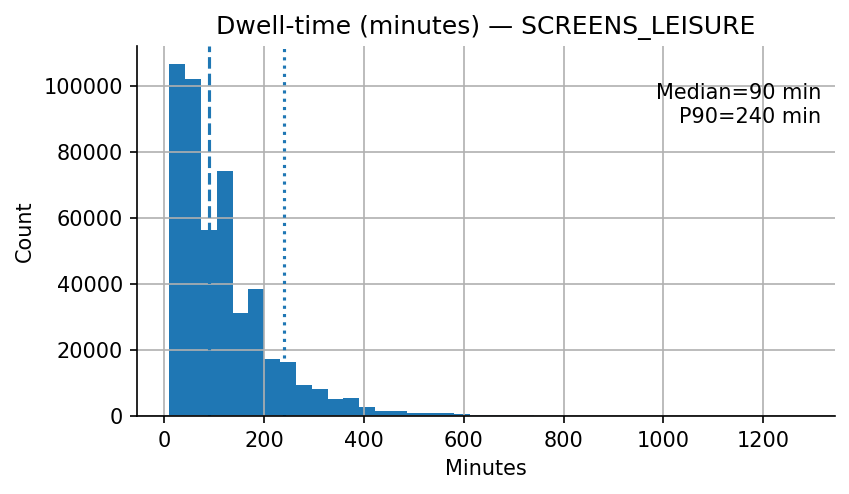

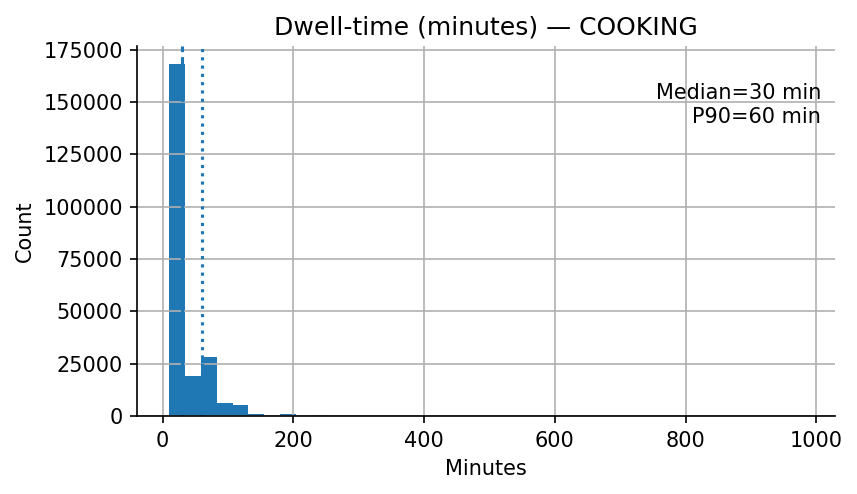

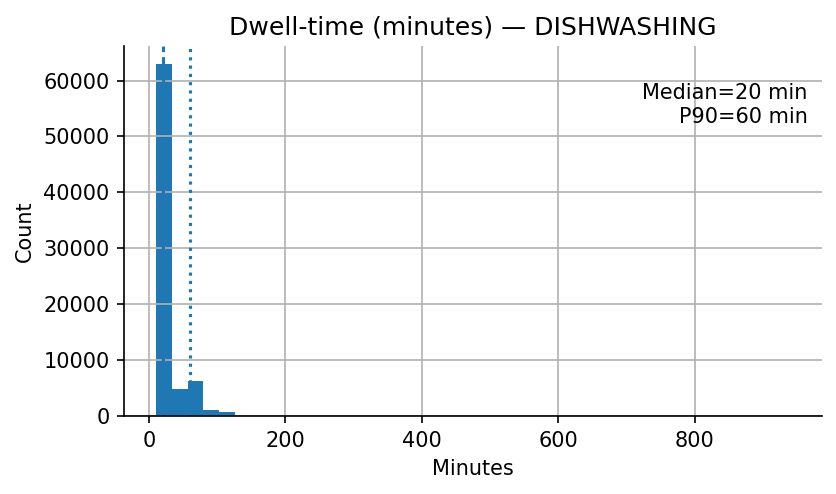

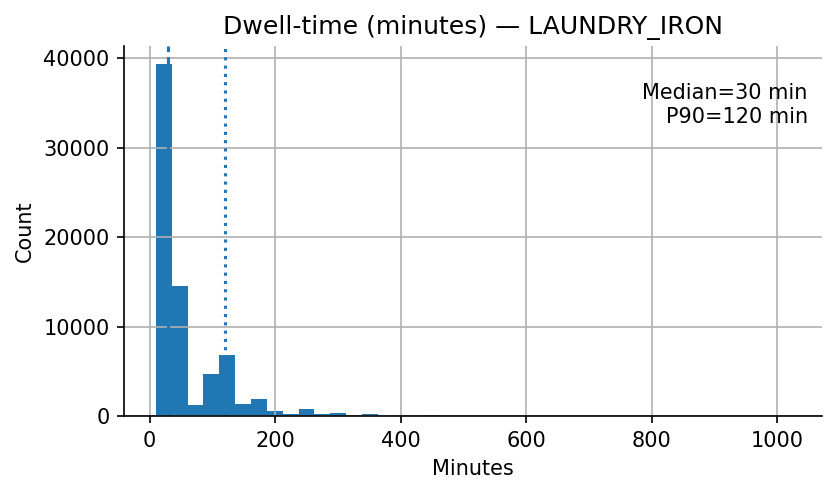

In [ ]:
DWELL_STATES = ["SLEEP", "SCREENS_LEISURE", "COOKING", "DISHWASHING", "LAUNDRY_IRON"]
for name in DWELL_STATES:
    if name not in sub_to_id:
        continue
    sid = sub_to_id[name]
    runs = dwell_time_samples(states, sid)  # in 10-min slots
    if not runs:
        continue
    durations_min = np.array(runs) * 10
    p50, p90 = np.percentile(durations_min, [50, 90])

    fig, ax = plt.subplots(figsize=(6, 3.2))
    ax.hist(durations_min, bins=40)
    ax.axvline(p50, ls="--"); ax.axvline(p90, ls=":")
    ax.set_title(f"Dwell-time (minutes) — {name}")
    ax.set_xlabel("Minutes"); ax.set_ylabel("Count")
    ax.text(0.98, 0.9, f"Median={p50:.0f} min\nP90={p90:.0f} min",
            transform=ax.transAxes, ha="right", va="top")
    fig.savefig(OUT_DIR / f"dwell_{name}.png", dpi=700)
    plt.show()


In [ ]:
def frob(a, b):  # a,b: K x 144
    d = a - b
    return np.sqrt((d*d).sum())

rows = []
rows.append(("Sex", "Male", "Female", frob(occ_m, occ_f)))
rows.append(("Employment", "Employed", "Unemployed", frob(occ_emp, occ_un)))
rows.append(("Day type", "Weekday", "Weekend", frob(occ_wd, occ_we)))
df_frob = pd.DataFrame(rows, columns=["Factor","Group A","Group B","Frobenius"])
to_table(df_frob, "frob_differences")
df_frob


,Factor,Group A,Group B,Frobenius
0,Sex,Male,Female,0.899121
1,Employment,Employed,Unemployed,0.967729
2,Day type,Weekday,Weekend,2.263643
